# **Financial Customer Complaint Classification**

**Group 4:**
Qidu (Quentin) Fu, Francisco Franco Arenas, Yixing (Leo) Zhu, Ximeng Deng

# 0 Setting up and loading data

## 0.1 Setting up pyspark

In [1]:
# Download neccessary libraries
!pip install pyspark -q
!pip install transformers -q
!pip install spark-nlp -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.4/568.4 kB 6.6 MB/s eta 0:00:00


In [2]:


# Import libraries

from pyspark.sql import SparkSession, DataFrame
from pyspark import SparkContext
from pyspark.sql import functions as fn
from pyspark.sql.functions import col, when, expr, split, size, length, regexp_replace, year
import matplotlib.pyplot as plt
import pandas as pd
import os
import sparknlp

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Initialize SparkSession
# spark = SparkSession\
#     .builder\
#     .appName("Consumer Complaints")\
#     .getOrCreate()

# FOR NLP pyspark
# Stop the existing Spark session if it's running
if 'spark' in locals():
    spark.stop()
spark = sparknlp.start()

BASE_PATH = '/content/drive/My Drive/BDA-Labs/'

Mounted at /content/drive


In [3]:
# Retrieve the data

!wget https://files.consumerfinance.gov/ccdb/complaints.csv.zip -O complaints.csv.zip
!unzip -o complaints.csv.zip -d /content/


--2024-04-24 21:56:10--  https://files.consumerfinance.gov/ccdb/complaints.csv.zip
Resolving files.consumerfinance.gov (files.consumerfinance.gov)... 13.35.116.98, 13.35.116.61, 13.35.116.65, ...
Connecting to files.consumerfinance.gov (files.consumerfinance.gov)|13.35.116.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 776046154 (740M) [binary/octet-stream]
Saving to: ‘complaints.csv.zip’

complaints.csv.zip  100%[===================>] 740.09M  88.3MB/s    in 9.0s    

2024-04-24 21:56:19 (82.5 MB/s) - ‘complaints.csv.zip’ saved [776046154/776046154]

Archive:  complaints.csv.zip
  inflating: /content/complaints.csv  


In [4]:
# Read the csv file
df = spark.read.csv("/content/complaints.csv",
                      header=True,
                      multiLine=True,
                      quote="\"",
                      escape="\"",
                      inferSchema=True)

# Define a cut off date
CUTOFF_DATE = "2024-01-01"
df = df.filter(fn.col("Date received") < fn.lit(CUTOFF_DATE))
# df.show(5)

In [ ]:
#df.groupby("Product").count().show(50,truncate=False)

## 0.2 Saving dataframes to and loading parquet files for computation reasons. Use below function. If the parquet already exists in your google drive, it will be loaded instead of being saved.

In [5]:
df.count()

4506194

NOTE: If the parquet exist, what I want is overwrite, not load what it is there, as then changes would not be stored.

In [6]:
# Save data for computational reason:


def save_and_load_data_to_parquet(df, filename):
    filepath = os.path.join(BASE_PATH, filename)
    # Check if the filepath, if yes not save the data befoe loading
    if not os.path.exists(filepath):
        if df is not None:
            # Write the df to a parquet file
            print('Saving to parquet ...')
            df.write.parquet(filepath, mode='overwrite')
            print('Data saved into parquet!')
        else:
            print('Dataframe is not defined')
    # Load the data from disk
    df = spark.read.parquet(filepath)
    print('Parquet file loaded from disk')
    return df


## 0.3 Removal of the existing parquet files

NOTE: this does not work. Parquet is a directory, not a file, ad os cannot remove it.

In [7]:
def remove_parquet_files(base_path):
    # List all files in the directory
    files = os.listdir(base_path)

    # Filter out files with the .parquet extension
    parquet_files = [file for file in files if file.endswith('.parquet')]

    # Remove each parquet file
    for file in parquet_files:
        filepath = os.path.join(base_path, file)
        os.remove(filepath)
        print(f'Removed: {filepath}')

# Call the function to remove parquet files
# remove_parquet_files(BASE_PATH)

## 0.4 FOR CODE TEST/EXPERIMENT ONLY, loading downsized dataframe.

In [ ]:
# df = save_and_load_data_to_parquet(df.limit(10000), 'testing_df.partquet')

# df.count()

# 1 Data Cleaning

## 1.1 Dropping NULLs, duplicates, select relevant features

In [8]:
# Drop null duplicates and complaint narratives of less than 800 words
def drop_null_duplicate(df):
  # Filter out rows where the complaint narrative is missing
  df_filtered = df.filter(df["Consumer complaint narrative"].isNotNull())

  # Remove duplicate rows
  df_filtered = df_filtered.dropDuplicates()

  # Keep only rows with complaint narratives of more than one word
  df_filtered = df_filtered.filter(size(split(col("Consumer complaint narrative"), "\s+")) > 1)

  # Keep only rows with complaint narratives of less than 800 words
  df_filtered = df_filtered.filter(size(split(col("Consumer complaint narrative"), "\s+")) < 800)
  return df_filtered

df = drop_null_duplicate(df)

## 1.2 Renaming categories of the target variable `Proudct`

In [9]:
df = df.withColumn("Product",
    when(col("Product") == "Prepaid card", "Credit card or prepaid card")
    .when(col("Product") == "Credit card", "Credit card or prepaid card")
    .when(col("Product").isin("Payday loan, title loan, personal loan, or advance loan",
                              "Payday loan, title loan, or personal loan",
                              "Vehicle loan or lease",
                              "Student loan",
                              "Mortgage"), "Loan")
    .when(col("Product") == "Credit reporting", "Credit reporting, credit repair services, or other personal consumer reports")
    .when(col("Product") == "Credit reporting or other personal consumer reports", "Credit reporting, credit repair services, or other personal consumer reports")
    .otherwise(col("Product"))
)

## 1.3 Selecting relevant features: `'Product', 'Sub-issue', 'Consumer complaint narrative', 'Company', 'ZIP code', 'Date sent to company'`

In [10]:
SELECTED_COLUMNS = ['Product', 'Sub-issue', 'Consumer complaint narrative',
                    'Company', 'ZIP code', 'Date sent to company']
df = df.select(SELECTED_COLUMNS).dropna()

In [10]:
df.groupby("Product").count().orderBy('count', ascending=False).show(truncate=False)

+----------------------------------------------------------------------------+------+
|Product                                                                     |count |
+----------------------------------------------------------------------------+------+
|Credit reporting, credit repair services, or other personal consumer reports|935833|
|Debt collection                                                             |230180|
|Credit card or prepaid card                                                 |117837|
|Checking or savings account                                                 |84374 |
|Loan                                                                        |74701 |
+----------------------------------------------------------------------------+------+



In [ ]:
df.write.parquet(os.path.join(BASE_PATH, "df.parquet"), mode="overwrite")


## 1.4 Cleaning text `Customer complaint narrative` and save the data to parquet

In [11]:
from pyspark.sql.functions import col, lower, regexp_replace, trim
from sparknlp.base import DocumentAssembler, Finisher
from sparknlp.annotator import Tokenizer, Normalizer, StopWordsCleaner, LemmatizerModel
from pyspark.ml import Pipeline
import sparknlp


def create_preprocess_pipeline():
    document_assembler = DocumentAssembler()\
                          .setInputCol('Consumer complaint narrative')\
                          .setOutputCol('document')

    tokenizer = Tokenizer()\
                  .setInputCols(['document'])\
                  .setOutputCol('token')

    normalizer = Normalizer()\
                  .setInputCols(['token'])\
                  .setOutputCol('normalized')\
                  .setLowercase(True)

    stopwords_cleaner = StopWordsCleaner()\
                          .setInputCols(['normalized'])\
                          .setOutputCol('cleanTokens')\
                          .setCaseSensitive(False)

    lemmatizer = LemmatizerModel.pretrained()\
                  .setInputCols(['cleanTokens'])\
                  .setOutputCol('lemma')

    finisher = Finisher()\
                  .setInputCols(['lemma'])\
                  .setOutputCols(['processed_narrative'])\
                  .setOutputAsArray(False)

    # Just return the Pipeline instance without calling it
    return Pipeline(stages=[
        document_assembler,
        tokenizer,
        normalizer,
        stopwords_cleaner,
        lemmatizer,
        finisher
    ])

def clean_text_column(df, input_col):
    # Convert text to lowercase
    df = df.withColumn(input_col, lower(col(input_col)))
    # Remove placeholders "XXXX"
    df = df.withColumn(input_col, regexp_replace(col(input_col), r'\bXXXX\b', ' '))
    # Remove dates in the format "XX/XX/YYYY".
    df = df.withColumn(input_col, regexp_replace(col(input_col), r'\bXX/XX/\d{4}\b', ' '))
    # Keep ASCII letters, digits, and spaces only
    df = df.withColumn(input_col, regexp_replace(col(input_col), r'[^A-Za-z0-9\s]', ' '))
    # Remove tokens with more than 'xx' inside
    # Using Spark SQL expr function to leverage the `translate` function for complex manipulation
    df = df.withColumn(input_col, expr(f"translate(`{input_col}`, 'xx', '  ')"))
    # Optional: further refine to replace multiple spaces with a single space if needed
    df = df.withColumn(input_col, regexp_replace(col(input_col), r'\s+', ' '))
    # Trim whitespace
    df = df.withColumn(input_col, trim(col(input_col)))
    return df

def apply_text_processing_with_regex_and_sparknlp(df, text_column, pipeline):
    df_cleaned = clean_text_column(df, text_column)
    # df_cleaned = df_cleaned.withColumnRenamed(text_column, "text")
    pipelineModel = pipeline.fit(df_cleaned)
    df_processed = pipelineModel.transform(df_cleaned)
    return df_processed

df = spark.read.parquet(os.path.join(BASE_PATH, "df.parquet"))

preprocess_pipeline = create_preprocess_pipeline()

df_text_processed = apply_text_processing_with_regex_and_sparknlp(df,
                                                "Consumer complaint narrative",
                                                preprocess_pipeline)
df_text_processed = df_text_processed.withColumn(
    "processed_narrative",
    regexp_replace("processed_narrative", "@", " ")  # Replace '@' with spaces
)
#df_text_processed.write.parquet(os.path.join(BASE_PATH, "df_text_processed.parquet"), mode="overwrite")


lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


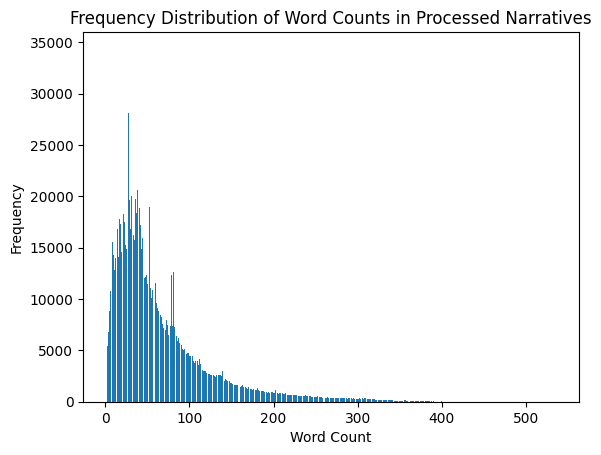

In [12]:
from pyspark.sql.functions import size, split, col
import matplotlib.pyplot as plt

df_text_processed = spark.read.parquet(os.path.join(BASE_PATH, "df_text_processed.parquet"))

df_word_counts = df_text_processed.withColumn("word_count", size(split(col("processed_narrative"), " ")))


# Compute the frequency distribution of the word counts
frequency_distribution = df_word_counts.groupBy("word_count").count()

# Collect the data to plot
data_to_plot = frequency_distribution.toPandas()

plt.figure()
plt.bar(data_to_plot['word_count'], data_to_plot['count'])
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Word Counts in Processed Narratives')
plt.show()


NOTE: please, do not add .show() as it implies running the complete spark query. Moreover, there is not computational difference between .show() and .sohw(5), as both need to bring the df to the central node.

In [13]:
from pyspark.sql.functions import explode, split, col


words_df = df_text_processed.withColumn("word", explode(split(col("processed_narrative"), " ")))

# Count word frequencies within each product
word_counts = words_df.groupBy("Product", "word").count()

# filter the top 10
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

windowSpec = Window.partitionBy("Product").orderBy(col("count").desc())
top_words_per_product = word_counts.withColumn("rank", row_number().over(windowSpec)) \
                                   .filter(col("rank") <= 10) \
                                   .select("Product", "word", "count", "rank")

top_words_per_product.show(60)


+--------------------+-----------+-------+----+
|             Product|       word|  count|rank|
+--------------------+-----------+-------+----+
|Checking or savin...|    account| 302470|   1|
|Checking or savin...|       bank| 186362|   2|
|Checking or savin...|      check| 121734|   3|
|Checking or savin...|       call|  94236|   4|
|Checking or savin...|      money|  78985|   5|
|Checking or savin...|       tell|  74560|   6|
|Checking or savin...|    receive|  62106|   7|
|Checking or savin...|        day|  61196|   8|
|Checking or savin...|    deposit|  60743|   9|
|Checking or savin...|       fund|  57648|  10|
|Credit card or pr...|       card| 266984|   1|
|Credit card or pr...|     credit| 239581|   2|
|Credit card or pr...|    account| 208927|   3|
|Credit card or pr...|     charge| 126526|   4|
|Credit card or pr...|    payment| 125395|   5|
|Credit card or pr...|       call| 124559|   6|
|Credit card or pr...|          e|  95891|   7|
|Credit card or pr...|       bank|  9586

In [ ]:

# print('df_text_processed: ')
# df_text_processed.show(5)

# 2 Feature engineering

In [ ]:
# df_text_processed.show()

In [ ]:
# df_text_processed.groupBy("Product").count().show()

## 2.1 Vectorization of `Consumer complaint narrative` with Bert


In [14]:
from pyspark.sql.functions import udf, pandas_udf, PandasUDFType
from pyspark.sql.types import StringType, ArrayType, FloatType
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
import spacy
import re

In [ ]:
# from sparknlp.annotator import Tokenizer, BertEmbeddings
# from sparknlp.base import DocumentAssembler
# from pyspark.ml import Pipeline

# # Read file
# df_text_processed = spark.read.parquet(os.path.join(BASE_PATH, "df_text_processed.parquet")).limit(5)

# # Define a function for building NLP embeddings
# def build_embedding_pipeline():
#     document_assembler = DocumentAssembler()\
#                           .setInputCol('processed_narrative')\
#                           .setOutputCol('document')
#     tokenizer = Tokenizer()\
#                   .setInputCols(['document'])\
#                   .setOutputCol('token')

#     bert_embedding = BertEmbeddings.pretrained("small_bert_L2_128", "en")\
#                         .setInputCols(['document', 'token'])\
#                         .setOutputCol('bert_embedding')

#     bert_pipeline = Pipeline().setStages([document_assembler,
#                                           tokenizer,
#                                           bert_embedding])
#     return bert_pipeline

# # Fit the pipeline to get a bert embedding as a column and remove unwanted columns
# def fit_embedding_pipeline(df, embedding_pipeline_fn):
#     bert_pipeline = embedding_pipeline_fn()
#     df_with_embeddings = bert_pipeline.fit(df).transform(df)

#     # Drop the 'document' and 'token' columns from the DataFrame
#     df_final = df_with_embeddings.drop('document', 'token')

#     return df_final

# # Get embeddings
# df_text_embed = fit_embedding_pipeline(df_text_processed,
#                                            build_embedding_pipeline)
# # Save embeddings to a local parquet file
# df_text_embed.write.parquet(os.path.join(BASE_PATH, "df_text_embed.parquet"),
#                                                             mode="overwrite")
# print('Embedding was saved!')
# # Read the embedding from a local parquet file
# df_text_embed = spark.read.parquet(os.path.join(BASE_PATH,
#                                                 "df_text_embed.parquet"))
# print('Embedding was loaded: df_text_embed')

#2.1 Alternative: IDF

In [12]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF
from pyspark.ml import Pipeline

# Tokenization
tokenizer = Tokenizer(inputCol="Consumer complaint narrative", outputCol="words")

# Remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered")

# Vectorize text
cv = CountVectorizer(inputCol="filtered",
                     outputCol="rawFeatures",
                      vocabSize = 500, # the size of the vocabulary
                     minDF = 2.0 #in how many documents must a vocabulary word appear
                     )

# Apply IDF
idf = IDF(inputCol="rawFeatures", outputCol="word_features") #min doc freq ignores word that appears in less than X documents

# Pipeline
wordVecPipeline = Pipeline(stages=[tokenizer, remover, cv, idf])


df_text_processed = spark.read.parquet(os.path.join(BASE_PATH, "df_text_processed.parquet"))

idfdf = wordVecPipeline.fit(df_text_processed).transform(df_text_processed)

#idfdf.write.parquet(os.path.join(BASE_PATH, "idfdf.parquet"),mode="overwrite")


##2.2 Encode month and day with cyclical transformation

In [14]:
from pyspark import keyword_only
from pyspark.ml import Transformer
from pyspark.ml.param.shared import Param, Params
from pyspark.sql.functions import col, month, dayofmonth, sin, cos, when
from math import pi

class DateFeatureTransformer(Transformer, Params):
    """
    A custom Transformer that adds date-related features to a DataFrame.
    """

    @keyword_only
    def __init__(self, inputCol=None, outputCols=None):
        super(DateFeatureTransformer, self).__init__()
        self.inputCol = Param(self, "inputCol", "")
        self.outputCols = Param(self, "outputCols", "")
        self._setDefault(inputCol=inputCol, outputCols=outputCols)

        if inputCol is not None:
            self.setInputCol(inputCol)
        if outputCols is not None:
            self.setOutputCols(outputCols)

    def setInputCol(self, value):
        """
        Sets the value of inputCol.
        """
        return self._set(inputCol=value)

    def setOutputCols(self, value):
        """
        Sets the value of outputCols.
        """
        return self._set(outputCols=value)

    def getInputCol(self):
        """
        Gets the value of inputCol or its default value.
        """
        return self.getOrDefault(self.inputCol)

    def getOutputCols(self):
        """
        Gets the value of outputCols or its default value.
        """
        return self.getOrDefault(self.outputCols)

    def _transform(self, df):
        # Define the expression for calculating the maximum number of days in a month
        max_days_expr = when(col("Month").isin(1, 3, 5, 7, 8, 10, 12), 31) \
            .when(col("Month").isin(4, 6, 9, 11), 30) \
            .when(col("Month") == 2, 28)

        # Apply transformations
        df_transformed = df.withColumn("Month", month(col(self.getInputCol()))) \
            .withColumn("Day", dayofmonth(col(self.getInputCol()))) \
            .withColumn("NormalizedDay", col("Day") / max_days_expr) \
            .withColumn("Month_sin", sin(col("Month") * (2 * pi) / 12)) \
            .withColumn("Month_cos", cos(col("Month") * (2 * pi) / 12)) \
            .withColumn("Day_sin", sin(col("NormalizedDay") * 2 * pi)) \
            .withColumn("Day_cos", cos(col("NormalizedDay") * 2 * pi))

        return df_transformed


# date transformer
date_transf = DateFeatureTransformer(inputCol="Date sent to company",
                                     outputCols=["Month", "Day", "NormalizedDay", "Month_sin", "Month_cos", "Day_sin", "Day_cos"])


##2.3 One hot enconde company

NO; There are 5.000 companies, too much, so we run out of memory

In [15]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer
#string indexer transformer
string_indexer = StringIndexer(inputCol = 'Company',
                               outputCol = 'Company_indexed',
                               handleInvalid = 'skip')
#ohe tranformer
ohe = OneHotEncoder(inputCol = 'Company_indexed',
                    outputCol = 'Company_ohe')

##2.4 Ensemble all transformation and creation of features for ML

In [16]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT

idfdf=spark.read.parquet(os.path.join(BASE_PATH, "idfdf.parquet"))

#vector assembler transformer
vector_assembler = VectorAssembler(
    inputCols = ['word_features','Month_sin', 'Month_cos', 'Day_sin','Day_cos'],
    outputCol = 'features')

#define pipeline
pipeline=Pipeline(stages=[date_transf, string_indexer, vector_assembler])


features_df = pipeline.fit(idfdf).transform(idfdf)


## 2.5 indexing the Product column for two stages ML

In [17]:
from pyspark.ml.feature import StringIndexer


#transformer to index Product
labelIndexer = StringIndexer(inputCol="Product", outputCol="Product_index")
#fit indexation
indexation = labelIndexer.fit(features_df)

#transform df
df_indexed = indexation.transform(features_df)

#first stage indexation, 0 for first category, 1 otherwise, in float type because it needs it for the confusion matrix
df_indexed = df_indexed.withColumn("first_stage_index",
                              when(col("product") == "Credit reporting, credit repair services, or other personal consumer reports", 0).otherwise(1))


#dictionary of labels
labels = indexation.labels

# Print the labels with their corresponding index
for index, label in enumerate(labels):
    print(f"Index {index}: Label {label}")

# df_indexed.show()

Index 0: Label Credit reporting, credit repair services, or other personal consumer reports
Index 1: Label Debt collection
Index 2: Label Credit card or prepaid card
Index 3: Label Checking or savings account
Index 4: Label Loan


In [ ]:
df_indexed.groupBy("Product_index").count().show()

## 2.5.5 Indexing and Downsampling for the 2nd stage ML

In [18]:

def downsampling_dataframe(df_indexed):

    # Filter out rows where Product_index is 0.0
    df_minor = df_indexed.filter(col("Product_index") != 0.0)

    # Randomly sample 50% of the rows where Product_index is 1.0
    df_debt = df_minor.filter(col("Product_index") == 1.0).sample(withReplacement=False, fraction=0.5, seed=718)

    # Keep all rows where Product_index is 2.0, 3.0, or 4.0
    df_kept = df_minor.filter(col("Product_index").isin(2.0, 3.0, 4.0))

    # Combine the debt and retained DataFrames
    df_SecondStage = df_debt.union(df_kept)

    return df_SecondStage

#df_SecondStage = downsampling_dataframe(df_indexed)



In [ ]:
#df_SecondStage.groupby("Product").count().show(truncate=False)


In [ ]:
# product_counts = df_SecondStage.groupby("Product").count().collect()
# pdf = pd.DataFrame(product_counts, columns=["Product", "Count"])
# import matplotlib.pyplot as plt

# # Plotting
# plt.figure(figsize=(10, 6))
# plt.bar(pdf['Product'], pdf['Count'])
# plt.xlabel('Product')
# plt.ylabel('Count')
# plt.title('Count of Products in Second Stage')
# plt.xticks(rotation=45)  # Rotate product names for better visibility if needed
# plt.show()

## 2.6 Splitting and vectorizing other data columns

NOTE: stratification might add computation expendises without really being needed, as a random split in big data shouls mantain distribution in both datasets.

In [19]:
#only save the useful features to save memory

df_indexed=df_indexed.select("Product","Product_index","first_stage_index","features")


df_train, df_test = df_indexed.randomSplit([0.8, 0.2], seed=42)

# #save to file test and train df
#save to file
df_test.write.parquet(os.path.join(BASE_PATH, "df_test.parquet"),mode="overwrite")
df_train.write.parquet(os.path.join(BASE_PATH, "df_train.parquet"),mode="overwrite")

In [ ]:
df_indexed.show()

# 3. Prediction models

## 3.1 First stage: Predict the majority class

In [20]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

df_test= spark.read.parquet(os.path.join(BASE_PATH, "df_test.parquet"))
df_train= spark.read.parquet(os.path.join(BASE_PATH, "df_train.parquet"))

#random forest model
rf = RandomForestClassifier(featuresCol="features",
                            labelCol="first_stage_index",
                            numTrees=80,
                            maxDepth=4,
                            maxBins=32)
#fit model
rf_model = rf.fit(df_train)
#get train predictions
train_predictions = rf_model.transform(df_train).withColumnRenamed("prediction", "first_stage_predictions")\
                                                .withColumnRenamed("rawPrediction", "rawPrediction_first_stage")\
                                                .withColumnRenamed("probability", "probability_first_stage")

#get test prediction
test_predictions = rf_model.transform(df_test).withColumnRenamed("prediction", "first_stage_predictions")\
                                                .withColumnRenamed("rawPrediction", "rawPrediction_first_stage")\
                                                .withColumnRenamed("probability", "probability_first_stage")
#crete evaluator
evaluator = BinaryClassificationEvaluator(labelCol="first_stage_index",rawPredictionCol="rawPrediction_first_stage")
# print metrics
train_roc_auc = evaluator.evaluate(train_predictions)
test_roc_auc = evaluator.evaluate(test_predictions)
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Test ROC AUC: {test_roc_auc}")

Train ROC AUC: 0.9108343913287731
Test ROC AUC: 0.911446990344491


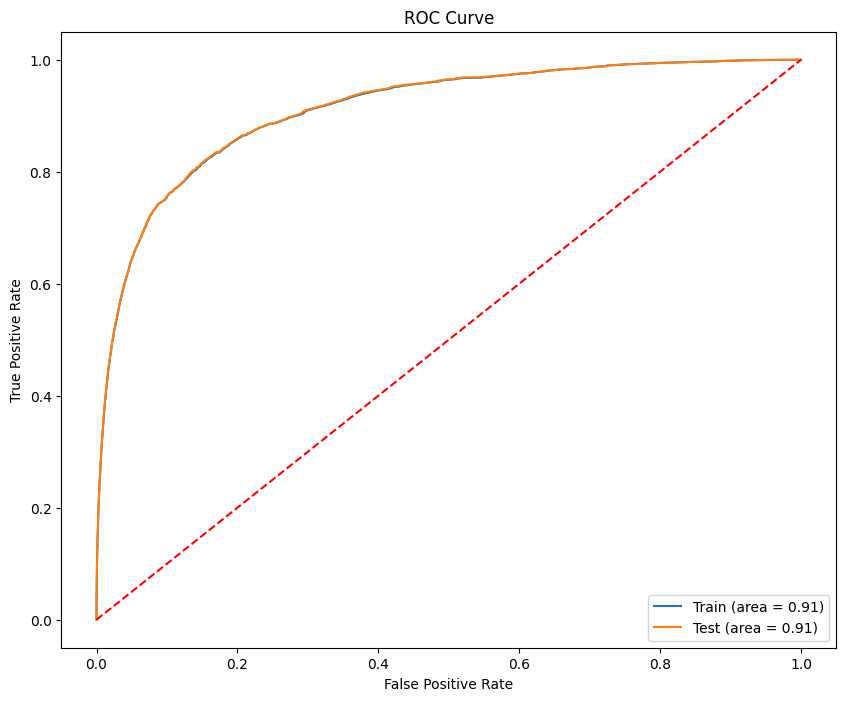

In [21]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import FloatType
import matplotlib.pyplot as plt

# UDF to extract probability of class 1
extract_prob = udf(lambda x: float(x[1]), FloatType())

# get the data
train_roc_data = train_predictions.withColumn("model_probability", extract_prob("probability_first_stage"))\
                                  .select("first_stage_index", "model_probability")
test_roc_data = test_predictions.withColumn("model_probability", extract_prob("probability_first_stage"))\
                                 .select("first_stage_index", "model_probability")

# Convert to Pandas
train_pdf = train_roc_data.toPandas()
test_pdf = test_roc_data.toPandas()

# plot ROC
def plot_roc_curve(true_values, predictions, label):
    from sklearn.metrics import roc_curve, auc

    fpr, tpr, _ = roc_curve(true_values, predictions)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (area = {roc_auc:.2f})')

plt.figure(figsize=(10, 8))
plot_roc_curve(train_pdf['first_stage_index'], train_pdf['model_probability'], 'Train')
plot_roc_curve(test_pdf['first_stage_index'], test_pdf['model_probability'], 'Test')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [22]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType


# Convert DataFrame to an RDD
predictionAndLabels = test_predictions.select(
    col('first_stage_predictions').cast(FloatType()),
    col('first_stage_index').cast(FloatType())
).rdd.map(lambda row: (row[0], row[1]))

# Instantiate MulticlassMetrics
metrics = MulticlassMetrics(predictionAndLabels)

# Confusion Matrix
confusionMatrix = metrics.confusionMatrix()

print("Confusion Matrix:")
print(confusionMatrix.toArray())

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
[[184582.   2443.]
 [ 60407.  40769.]]


##3.2 Second stage: Predict the minority class

In [23]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Filter the training data for instances not credit instances
#train_second_stage = df_train.filter("first_stage_index==1")
# Filter the test predictions for instances predicted as not credit in the first stage
#test_second_stage = test_predictions.filter("first_stage_predictions==1")

train_second_stage = downsampling_dataframe(df_train)
test_second_stage = downsampling_dataframe(df_test)


# Initialize the RandomForestClassifier for the second stage with specific settings
rf_multiclass = RandomForestClassifier(featuresCol="features",
                                       labelCol="Product_index",
                                       numTrees=100,
                                       maxDepth=4,
                                       maxBins=32)

# Fit the second-stage multiclass random forest model on the filtered training data
multiclass_rf_model = rf_multiclass.fit(train_second_stage)

# Transform the second-stage training data with the fitted model and rename the output columns for clarity
train_predictions_multiclass = multiclass_rf_model.transform(train_second_stage)\
                                                .withColumnRenamed("prediction", "second_stage_predictions")\
                                                .withColumnRenamed("rawPrediction", "rawPrediction_second_stage")\
                                                .withColumnRenamed("probability", "probability_second_stage")

# Transform the second-stage test data with the fitted model and rename the output columns for clarity
test_predictions_multiclass = multiclass_rf_model.transform(test_second_stage)\
                                                .withColumnRenamed("prediction", "second_stage_predictions")\
                                                .withColumnRenamed("rawPrediction", "rawPrediction_second_stage")\
                                                .withColumnRenamed("probability", "probability_second_stage")

# Initialize the MulticlassClassificationEvaluator with the F1 metric and the appropriate label and Prediction columns
evaluator = MulticlassClassificationEvaluator(labelCol="Product_index", metricName="f1", predictionCol="second_stage_predictions")

# Evaluate the F1 score of the second-stage model on both the training and test predictions
train_f1_score = evaluator.evaluate(train_predictions_multiclass)
test_f1_score = evaluator.evaluate(test_predictions_multiclass)

# Print the F1 scores for the training and test datasets
print(f"Train F1 Score: {train_f1_score}")
print(f"Test F1 Score: {test_f1_score}")

Train F1 Score: 0.763486814657958
Test F1 Score: 0.7645873783466283


In [24]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.functions import col

# Convert DataFrame to an RDD for train predictions
predictionAndLabels_train = train_predictions_multiclass.select(
    col('second_stage_predictions').cast('double'),
    col('Product_index').cast('double')
).rdd.map(tuple)

# Instantiate MulticlassMetrics for train predictions
metrics_train = MulticlassMetrics(predictionAndLabels_train)

# Confusion Matrix for train predictions
confusionMatrix_train = metrics_train.confusionMatrix().toArray()

# Print the Confusion Matrix for train predictions
print("Training Data Confusion Matrix:")
print(confusionMatrix_train)

# Convert DataFrame to an RDD for test predictions
predictionAndLabels_test = test_predictions_multiclass.select(
    col('second_stage_predictions').cast('double'),
    col('Product_index').cast('double')
).rdd.map(tuple)

# Instantiate MulticlassMetrics for test predictions
metrics_test = MulticlassMetrics(predictionAndLabels_test)

# Confusion Matrix for test predictions
confusionMatrix_test = metrics_test.confusionMatrix().toArray()

# Print the Confusion Matrix for test predictions
print("Test Data Confusion Matrix:")
print(confusionMatrix_test)


Training Data Confusion Matrix:
[[78832.  9990.   705.  2419.]
 [ 6505. 83933.  3002.   805.]
 [ 2588. 24064. 40670.   442.]
 [ 8890. 13005.  1147. 36728.]]
Test Data Confusion Matrix:
[[19739.  2500.   163.   638.]
 [ 1641. 21030.   725.   196.]
 [  646.  5870.  9963.   131.]
 [ 2211.  3229.   283.  9203.]]


## 3.3 Merge both predictions and obtain confusion matrix

In [25]:
from pyspark.sql.functions import lit, col
from pyspark.sql.types import DoubleType

# drop the unnecessary columns from the second-stage predictions
test_predictions_multiclass = test_predictions_multiclass.select(
    'Product_index', 'features', 'first_stage_index', 'second_stage_predictions'
)

# include all columns in the second-stage predictions DataFrame
test_predictions = test_predictions.withColumn(
    "second_stage_predictions", lit(0).cast(DoubleType())
).select(
    'Product_index', 'features', 'first_stage_index', 'second_stage_predictions'
)

# union the two DataFrames
merged_df = test_predictions_multiclass.union(test_predictions)



In [26]:
from pyspark.sql.functions import lit
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

# merged_df.write.parquet("/content/merged_df.parquet",mode="overwrite")




In [27]:
from pyspark.mllib.evaluation import MulticlassMetrics

#merged_df= spark.read.parquet("/content/merged_df.parquet")


final_f1_score = evaluator.evaluate(merged_df)
print(f"Total F1 Score: {final_f1_score}")


# Convert DataFrame to an RDD
predictionAndLabels = merged_df.select(['second_stage_predictions', 'Product_index']).rdd.map(lambda x: (x[0], x[1]))

# Instantiate MulticlassMetrics
metrics = MulticlassMetrics(predictionAndLabels)

# Confusion Matrix
confusionMatrix = metrics.confusionMatrix()

print("Confusion Matrix:")
print(confusionMatrix.toArray())


Total F1 Score: 0.6276493957707988
Confusion Matrix:
[[1.87025e+05 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [4.60480e+04 1.97390e+04 2.50000e+03 1.63000e+02 6.38000e+02]
 [2.35920e+04 1.64100e+03 2.10300e+04 7.25000e+02 1.96000e+02]
 [1.66100e+04 6.46000e+02 5.87000e+03 9.96300e+03 1.31000e+02]
 [1.49260e+04 2.21100e+03 3.22900e+03 2.83000e+02 9.20300e+03]]


In [29]:
np.set_printoptions(formatter={'float': '{: 0.0f}'.format})
print("Confusion Matrix:")
print(confusionMatrix.toArray())

Confusion Matrix:
[[ 187025  0  0  0  0]
 [ 46048  19739  2500  163  638]
 [ 23592  1641  21030  725  196]
 [ 16610  646  5870  9963  131]
 [ 14926  2211  3229  283  9203]]


# 4. Try Gradient Boost

In [30]:
from pyspark.ml.classification import GBTClassifier

# Fit the first stage GBT model
gbt_first_stage = GBTClassifier(featuresCol="features", labelCol="first_stage_index", maxIter=20)
gbt_model_first_stage = gbt_first_stage.fit(df_train)
train_predictions_gbt = gbt_model_first_stage.transform(df_train)
test_predictions_gbt = gbt_model_first_stage.transform(df_test)

# Evaluate the first stage GBT model
binary_evaluator_gbt = BinaryClassificationEvaluator(labelCol="first_stage_index", rawPredictionCol="rawPrediction")
train_roc_auc_gbt = binary_evaluator_gbt.evaluate(train_predictions_gbt)
test_roc_auc_gbt = binary_evaluator_gbt.evaluate(test_predictions_gbt)
print(f"GBT Train ROC AUC: {train_roc_auc_gbt}")
print(f"GBT Test ROC AUC: {test_roc_auc_gbt}")


GBT Train ROC AUC: 0.9328981656836343
GBT Test ROC AUC: 0.9335637035715696
